In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from arch.unitroot import PhillipsPerron,DFGLS
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

## Macroeconomic Data

To construct our indicator, we download some macroeconomic data from Wind Data Service. Since a subscription account is required to get access to Wind Data Service, we just downloaded the data and put it on the GitHub within our project. 
In particular, the variables we obtained are displayed below in code cell.

Since we want our indicator to implicate the correlation of supply, demand, and inflation of macroeconomy of China, 
we select variables from these three aspects.

In [31]:
data = pd.read_csv('https://raw.githubusercontent.com/koueihei/Project-for-math-data-skills-YG/main/Data_and_code/MacroData.csv')
data = data.assign(Dates=pd.to_datetime(data.Dates)).set_index('Dates')

datainfo = {}
for ts in data.columns:

    datainfo[ts]={
        'Count':data[ts].count(),
        'Start point': data[ts].dropna().index[0].strftime("%m/%d/%Y"),
        'End point': data[ts].dropna().index[-1].strftime("%m/%d/%Y")
        }
datainfo_df = pd.DataFrame(datainfo)#.items(),columns=['Var','P values of P-p test'])

datainfo_df=datainfo_df.T 
mapper =  {
        'Count':'{:.0f}',
        }

datainfo_df.style.format(mapper)

,Count,Start point,End point
Average daily coal consumption,3916,10/01/2009,07/06/2020
Operating rate of blast furnaces,475,08/03/2012,12/24/2021
All-steel wheel operating rate,414,06/01/2013,01/06/2022
Semi-steel wheel operating rate,410,07/18/2013,01/06/2022
Polyester filament operating rate,508,09/04/2013,01/06/2022
PTA operating rate,413,09/01/2013,01/07/2022
Average daily output of crude steel,459,01/10/2009,12/20/2021
Commercial housing transaction area of 30 cities(D),4392,01/01/2010,01/09/2022
Commercial housing transaction area of 30 cities(W),628,01/03/2010,01/09/2022
Cement Price Index,2402,09/09/2011,01/10/2022


To denote which aspect a variable represent, we create a mapping to index them, where "s" represents supply, "d" represents demand, and "p" represents inflation or price level. For instance, "s1" represents "Average daily coal consumption", the first variable from supply aspect.

In [32]:
keys = ('s1','s2','s3','s4','s5','s6','s7','d1','d2','d3','d4','d5','d6','d7','p1','p2','p3','s8','s9','s10','s11','s12')
indexing = dict(zip(data.columns.to_list(),keys))
reindexing = dict(zip(keys,data.columns.to_list()))

For data missing problem, we only select the data from Jun/10/2016 to Dec/31/2021.
As for missing data points within this period, we use linear interpolation to fill them.
Since many variables have trends, we take first difference to make them stationary.
The cleaned data are contained in data3.

In [43]:
data1 = data.rename(columns = indexing).interpolate(method='linear')
data2 = data1.resample('W').mean().loc['2016-06-19':'2021-12-31',:]
data3 = data2.pct_change().dropna(how='all',axis=0)
data3.loc['2020-7-13':,'s1'] = np.nan


### Basic Statistical Description of Data and Unit Root Test 

In [44]:
#basic description of variables
data3info = {}
for ts in data3.columns:
    pp = PhillipsPerron(data3[ts].dropna())#PhillipsPerron(data3[ts].dropna())
    data3info[reindexing[ts]]={
        'index':ts,
        'P values <br> of P-p test':pp.pvalue, #print newline within a cell of pandas
        'Mean':data3[ts].mean(),
        'Count':data3[ts].count(),
        'Std':data3[ts].std(),
        'Skewness':data3[ts].skew(),
        'Kurtosis':data3[ts].kurtosis(),
        'Start point': data3[ts].dropna().index[0].strftime("%m/%d/%Y"),
        'End point': data3[ts].dropna().index[-1].strftime("%m/%d/%Y")
        }
data3info_df = pd.DataFrame(data3info)#.items(),columns=['Var','P values of P-p test'])

data3info_df=data3info_df.T 
mapper =  {
        'P values <br> of P-p test':'{0:.2e}',
        'Mean':'{0:.3f}',
        'Count':'{:.0f}',
        'Skewness':'{0:.3f}',
        'Kurtosis':'{0:.3f}'
        }

data3info_df.sort_values('index').style.format(mapper)

,index,P values of P-p test,Mean,Count,Std,Skewness,Kurtosis,Start point,End point
Commercial housing transaction area of 30 cities(D),d1,4.01e-30,0.105,288,0.809328,8.473,85.929,06/26/2016,12/26/2021
Commercial housing transaction area of 30 cities(W),d2,3.48e-24,0.035,288,0.327938,6.219,64.380,06/26/2016,12/26/2021
Cement Price Index,d3,1.69e-04,0.003,288,0.014577,2.207,10.875,06/26/2016,12/26/2021
Average Daily Sales of Passenger Car(Wholesale),d4,2.06e-30,0.061,288,0.367120,1.615,7.937,06/26/2016,12/26/2021
Average Daily Sales of Passenger Car(Retail),d5,0.00e+00,0.060,288,0.350020,0.759,1.746,06/26/2016,12/26/2021
Keqiao Textile Price Index,d6,3.64e-16,0.000,288,0.001505,-0.020,2.122,06/26/2016,12/26/2021
CCFI composite index,d7,4.06e-05,0.006,288,0.017604,1.099,2.703,06/26/2016,12/26/2021
Edible Agricultural Products Price Index,p1,1.35e-05,0.000,288,0.010150,0.376,2.147,06/26/2016,12/26/2021
Production price index,p2,1.63e-10,0.002,288,0.007235,1.824,12.310,06/26/2016,12/26/2021
WTI spot price,p3,2.19e-26,0.006,288,0.103793,8.206,121.001,06/26/2016,12/26/2021


### Select Data to Represent Supply, Demand, and Inflation

Since the variables we get may have multicolinearity within one aspect, we further select the data to get rid of it.

#### Variables of Supply

In [45]:
# Variables of supply

setS = ['s1','s2','s3','s5','s6','s8']
print(np.corrcoef(data3[setS].dropna().T))


[[ 1.          0.04421198  0.28707713  0.30549748  0.03734154  0.3127957 ]
 [ 0.04421198  1.          0.07853942  0.00480322 -0.04282329  0.24113744]
 [ 0.28707713  0.07853942  1.          0.67573823 -0.11027179  0.0071115 ]
 [ 0.30549748  0.00480322  0.67573823  1.         -0.11738447  0.10021514]
 [ 0.03734154 -0.04282329 -0.11027179 -0.11738447  1.         -0.01712484]
 [ 0.3127957   0.24113744  0.0071115   0.10021514 -0.01712484  1.        ]]


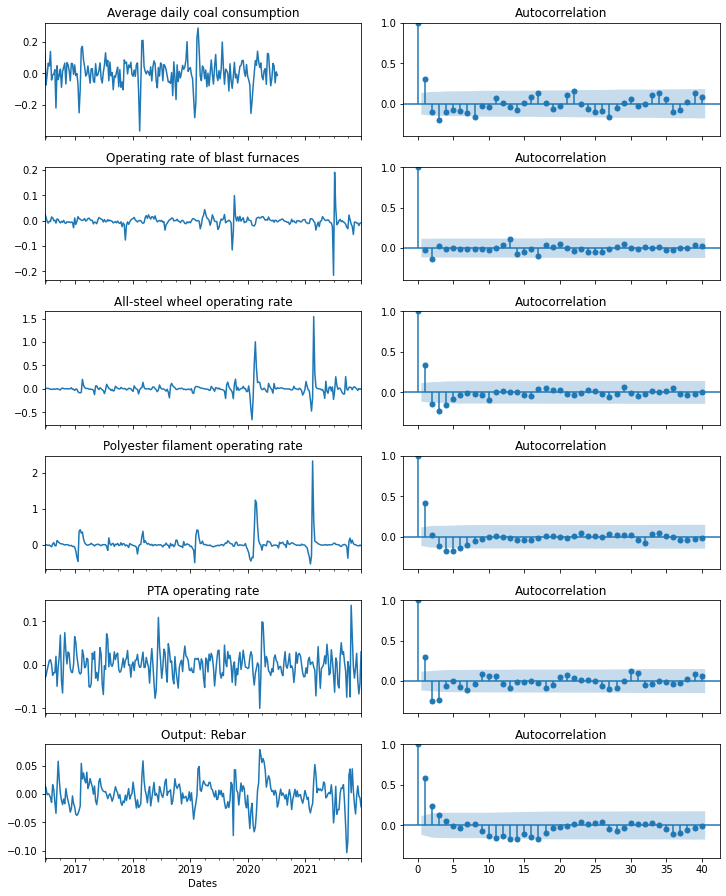

In [46]:
fig1, ax1 = plt.subplots(6,2,figsize=(10,12))
fig1.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)
for i,ts in enumerate(setS):
    data3[ts].plot(ax=ax1[i,0])
    plot_acf(data3[ts].dropna(), lags=40,ax=ax1[i,1])
    ax1[i,0].set_title(reindexing[ts])
    ax1[i,1].set_title('Autocorrelation')
    ax1[i,1].set_ylim([-0.4,1])
    ax1[i,0].sharex(ax1[0,0])
    ax1[i,1].sharex(ax1[0,1])

#### Variables of Demand

In [47]:
# Variables of Demand

setD = ['d2','d3','d5','d6','d7']
print(np.corrcoef(data3[setD].dropna().T))

[[ 1.00000000e+00 -8.76630149e-02  2.47389064e-01  8.63547976e-02
  -1.70524010e-01]
 [-8.76630149e-02  1.00000000e+00  7.59510897e-04  4.77053495e-02
  -4.77956901e-02]
 [ 2.47389064e-01  7.59510897e-04  1.00000000e+00 -7.30288395e-02
  -2.45011092e-02]
 [ 8.63547976e-02  4.77053495e-02 -7.30288395e-02  1.00000000e+00
  -3.73765588e-02]
 [-1.70524010e-01 -4.77956901e-02 -2.45011092e-02 -3.73765588e-02
   1.00000000e+00]]


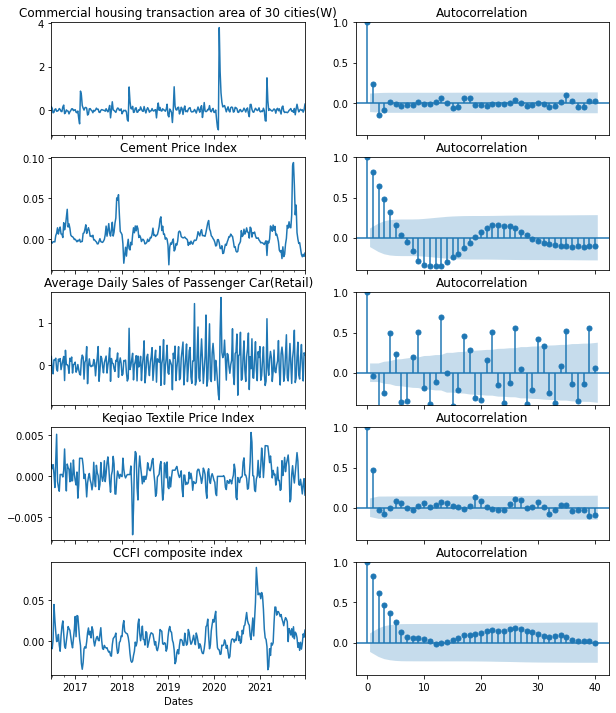

In [48]:
fig2, ax2 = plt.subplots(5,2,figsize=(10,12))
fig1.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)
for i,ts in enumerate(setD):
    data3[ts].plot(ax=ax2[i,0])
    plot_acf(data3[ts].dropna(), lags=40,ax=ax2[i,1])
    ax2[i,0].set_title(reindexing[ts])
    ax2[i,1].set_title('Autocorrelation')
    ax2[i,1].set_ylim([-0.4,1])
    ax2[i,0].sharex(ax2[0,0])
    ax2[i,1].sharex(ax2[0,1])

#### Variables of Price

In [49]:
# Variables of Price

setP = ['p1','p2','p3']
print(np.corrcoef(data3[setD].dropna().T))

[[ 1.00000000e+00 -8.76630149e-02  2.47389064e-01  8.63547976e-02
  -1.70524010e-01]
 [-8.76630149e-02  1.00000000e+00  7.59510897e-04  4.77053495e-02
  -4.77956901e-02]
 [ 2.47389064e-01  7.59510897e-04  1.00000000e+00 -7.30288395e-02
  -2.45011092e-02]
 [ 8.63547976e-02  4.77053495e-02 -7.30288395e-02  1.00000000e+00
  -3.73765588e-02]
 [-1.70524010e-01 -4.77956901e-02 -2.45011092e-02 -3.73765588e-02
   1.00000000e+00]]


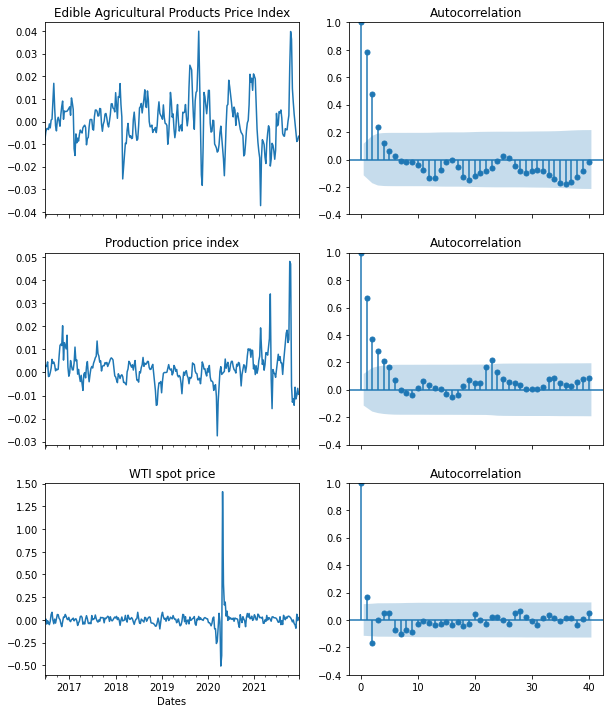

In [50]:
fig3, ax3 = plt.subplots(3,2,figsize=(10,12))
fig1.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)
for i,ts in enumerate(setP):
    data3[ts].plot(ax=ax3[i,0])
    plot_acf(data3[ts].dropna(), lags=40,ax=ax3[i,1])
    ax3[i,0].set_title(reindexing[ts])
    ax3[i,1].set_title('Autocorrelation')
    ax3[i,1].set_ylim([-0.4,1])
    ax3[i,0].sharex(ax3[0,0])
    ax3[i,1].sharex(ax3[0,1])

In [51]:
#automatically drop s1 when there is no available data for s1
def check_nan(data):
    '''
    ckeck if there are any nans in data and drop them.
    input -> pandas dataframe
    return -> data without nan, number of series remained
    '''
    checker = data.isnull().any(axis=0)
    if checker.any()==True:
        columns = checker[checker == 0].index.tolist()
        return data[columns], len(columns)
    else:
        return data, data.shape[1]
